In [0]:
# Import libraries

import numpy as np
import random as rand
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import queue as Q
from matplotlib.colors import ListedColormap
import time
import pprint as pp
import pandas as pd
from operator import itemgetter

In [0]:
dim = 150
p = 0.2
start = (0,0)
goal = (dim-1,dim-1)

In [0]:
def generate_maze(dim = 10, p = 0.4):
    
    rows = dim
    cols = dim
    mat = np.ones((dim,dim), dtype=int)
    
    for i in range(rows):
        for j in range(cols):
            if( rand.uniform(0,1) < p ):    ##if random number is greater than p, it is occupied
                mat[i][j] = 0
    
    mat[0][0] = 1
    mat[dim-1][dim-1] = 1
    
    return mat 

In [0]:
def visualise_maze(maze):
  plt.figure(figsize=(15,15))
  ax = sns.heatmap(maze, linewidths=.5,square = True, cbar=False, xticklabels=False, yticklabels=False)
  plt.show()

In [0]:
def check_child_validity(maze,vertex,visited):
    
    dim = maze.shape[0] 

    # If dimensions are in the range
    if vertex[0]==-1 or vertex[1]==-1 or vertex[0]==dim or vertex[1]==dim:
        return False
    # If node is closed
    elif maze[vertex[0],vertex[1]]==0 or vertex in visited:
        return False
    else:
        return True

In [0]:
def display_path(maze_temp, prev_list, start, goal):
  
    prev_node = goal
    path = [prev_node]
    maze_temp[prev_node] = 25
    
    if bool(prev_list):
      while(prev_list[prev_node] != start):
        current_node = prev_node
        prev_node = prev_list[(current_node)]
        path.append(prev_node)
        maze_temp[prev_node] = 50
        
      path.append(prev_list[prev_node])
      path.reverse()
      maze_temp[prev_list[prev_node]] = 25
      
      path_length = str(len(path))

      plt.figure(figsize = (15,15))
      sns.heatmap(maze_temp, cmap=ListedColormap(['black', 'green', 'crimson', 'papayawhip']), linewidths=.5, square = True, cbar=False, xticklabels=False, yticklabels=False)
      plt.show()
      
      return path_length

In [0]:
def path_length(goal, prev_list, start):
    
    prev_node = goal
    path = [prev_node]
    path_len = 0
    
    if bool(prev_list):
        while(prev_node in prev_list.keys() and prev_list[prev_node] != start):
            current_node = prev_node
            prev_node = prev_list[(current_node)]
            path.append(prev_node)
        
        path.append(prev_list[prev_node])
        path.reverse()

        path_len = len(path)
    
    return path_len, path

##HILL CLIMBING

In [0]:
def prioritize_children(maze, goal, visited, x, y):
  
    children = []
    node = []
    h = []
    
    node.append((x+1, y))
    h.append((goal - node[0][0]) + (goal - node[0][1]))

    
    node.append((x, y+1))
    h.append((goal - node[1][0]) + (goal - node[1][1]))
    
    node.append((x-1, y))
    h.append((goal - node[2][0]) + (goal - node[2][1]))
    
    node.append((x, y-1))
    h.append((goal - node[3][0]) + (goal - node[3][1]))
    
    for i in range(4):
        ind = h.index(min(h))
        h.pop(ind)
        current_child = node.pop(ind)
        if(check_child_validity(maze,current_child,visited)):
            children.append(current_child)
    
    children.reverse()
    return children

In [0]:
def improved_DFS(maze, start, goal):
  
    fringe = [start]
    visited = [start]
    prev_list = {}
    
    count_of_nodes = 0
    max_fringe_size = 0
    
    while fringe:
        (i, j) = fringe.pop()
        count_of_nodes+=1
        max_fringe_size = max( max_fringe_size, len(fringe) )
        
        if (i, j) == goal:
            return 1, prev_list, count_of_nodes, max_fringe_size, visited
           
        # Generating and adding child nodes in fringe 
        children = prioritize_children(maze,goal[0]-1,visited,i,j)
        if children:
          for c in children:
            prev_list[c] = (i,j)
            fringe.append(c)
            visited.append(c)
     
    return 0, prev_list, count_of_nodes, max_fringe_size, visited

### Fitting/Cost function for hill climbing:

In [0]:
def calculate_cost(maze,start,goal):

        is_goal_reached, prev_list, count_of_nodes, max_fringe_size, visited = improved_DFS(maze, start, goal)   # Improved DFS is used here for finding the path
              
        if(is_goal_reached):
            shortest_path_length, path = path_length(goal, prev_list, start)
            cost = (shortest_path_length) + (count_of_nodes)   # based on parameters shortest path length and count of nodes
        else:
          cost = 0
          path = [(0,1)]
        
        return cost, is_goal_reached, path

### Function to run Hill climbing on single maze:

Here, we have taken the number of restarts as 100. This allows the algorithm to explore different options in case it gets stuck at local optima or generates a maze which is not solvable.

In [0]:
def hill_climbing(dim, p, num_restarts):
    
    start = (0,0)
    goal = (dim-1,dim-1)
  
    
    print("INITITAL MAZE")

    while True:
      maze = generate_maze(dim,p)
      cost,is_reachable,path = calculate_cost(maze,start,goal)
      if is_reachable:
        break
        
    prev_maze = maze
    hardest_maze = np.copy(maze)   # Stores the hardest maze encountered throughout each exploration step
    max_cost = 0
    
    is_goal_reached, prev_list, count_of_nodes, max_fringe_size, visited = improved_DFS(maze, start, goal)
    maze_temp = maze*100
    display_path(maze_temp, prev_list, start, goal)
    
    og_cost = cost # cost of original maze
    cost_at_local_maxima = [og_cost]
    print("Cost of Initial Maze: " + str(cost))
    count = 0;
    
    # Here termination condition is if number of restarts exceeds 100 or the cost function of hardest maze found is greater than 7 times the original maze.
    while count < num_restarts:
      while True:  
          # We are generating a neighbouring maze of existing maze by mutating a cell (addition or deletion of obstacle) of the path.
          
          mutate_cell = rand.choice(path)  # selecting a cell from the existing path found
          if mutate_cell == start or mutate_cell == goal:
              continue
          else:
              prev_maze = np.copy(maze)
              maze[mutate_cell] = 0
              maze[mutate_cell[1]][mutate_cell[0]] = 1

              new_cost, new_is_reachable,new_path = calculate_cost(maze,start,goal)  # Finding cost of new neighbour matrix

              if new_is_reachable:
                cost = new_cost
                path = new_path

              else:
                maze = np.copy(prev_maze)
                if cost > max_cost:         # Check for harder maze
                  max_cost = cost
                  hardest_maze = np.copy(maze)
                count += 1
                cost_at_local_maxima.append(cost)
                break
      if cost > 7*og_cost:  # Check for terminating condition
        break
            
    return hardest_maze, max_cost, og_cost, cost_at_local_maxima

#### The below function is for running the hill climb on multiple mazes (num_iterations) to find the hardest of them all.

In [0]:
def multiple_hc(num_restarts, num_iterations):
  
  difference = []
  final_maze = (generate_maze(dim, p), 0, {}) # Hardest maze of all
  
  for i in range(num_iterations):
    
    hardest_maze, max_cost, og_cost, y = hill_climbing(dim, p, num_restarts) # Return the hardest maze for a given original maze
    print("HARDEST MAZE")
    is_goal_reached, prev_list, count_of_nodes, max_fringe_size, visited = improved_DFS(hardest_maze, start, goal)
    hardest_temp = np.copy(hardest_maze)*100
    display_path(hardest_temp, prev_list, start, goal)
    print("Cost of Hardest Maze: " + str(max_cost))
    
    if max_cost > final_maze[1]:
      final_maze = (hardest_maze, max_cost, prev_list)
    
    # Display the path in the hardest maze
    x = np.arange(0,len(y))
    sns.set(style="whitegrid", color_codes=True)
    plt.figure(figsize = (15,10))
    sns.lineplot(x, y)
    plt.xlabel("Local Maxima #")
    plt.ylabel("Cost of the Maze (Max. fringe size)")
    plt.title("Costs of mazes at local maxima")
    difference.append((max_cost - og_cost)/og_cost)
    print("Difference between initial and hardest maze: " + str(difference[i]))
    
  return final_maze, difference

INITITAL MAZE


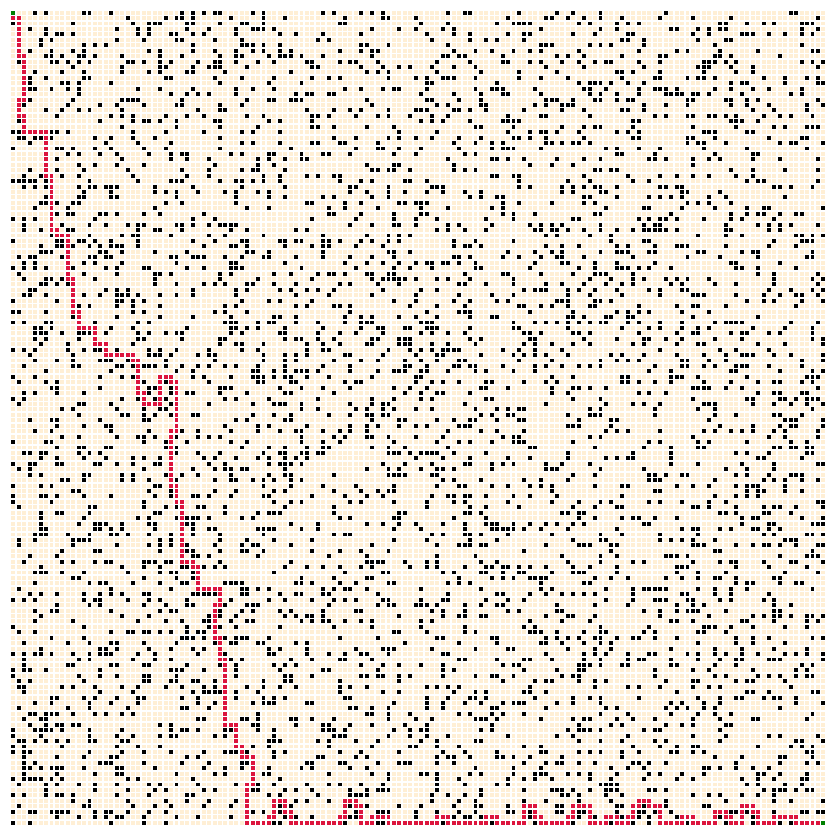

Cost of Initial Maze: 767
HARDEST MAZE


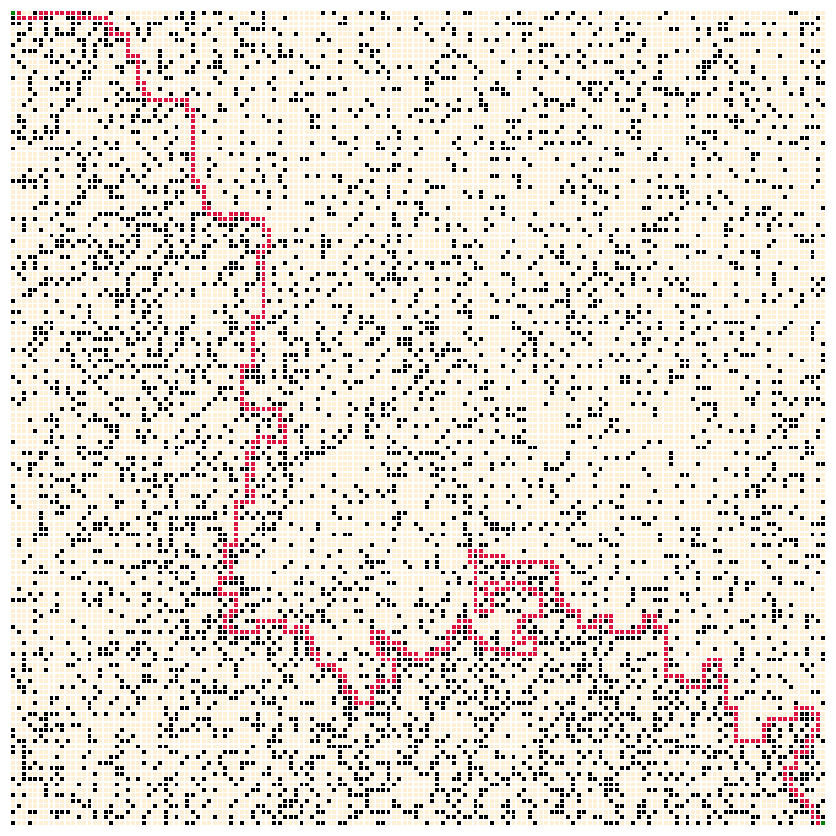

Cost of Hardest Maze: 5487
Difference between initial and hardest maze: 6.153846153846154
INITITAL MAZE


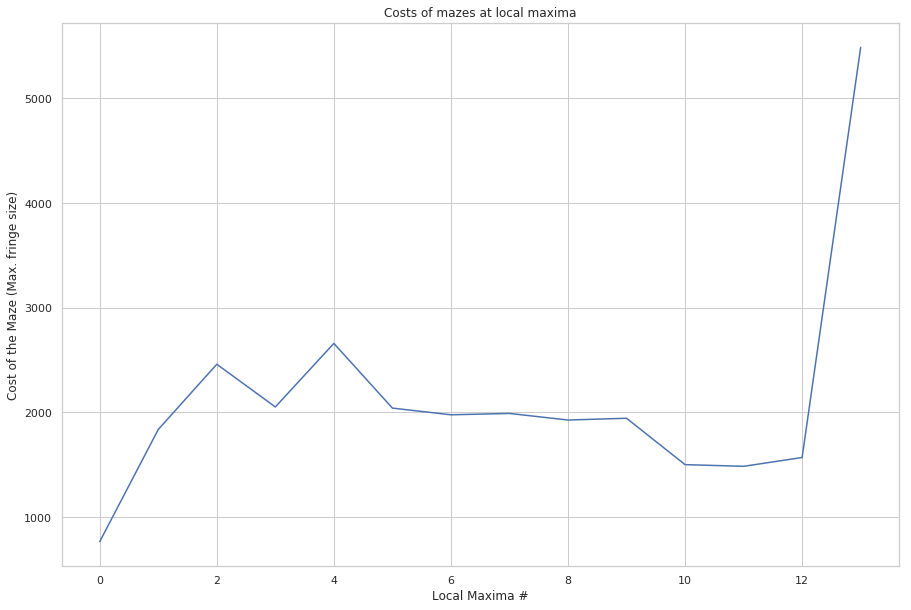

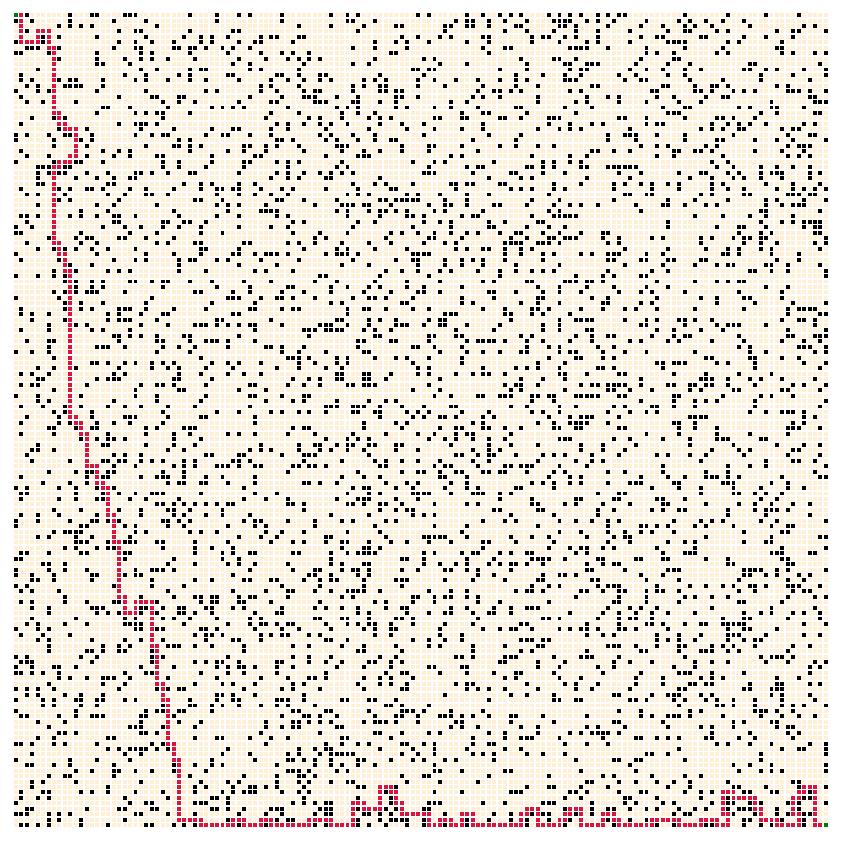

Cost of Initial Maze: 820
HARDEST MAZE


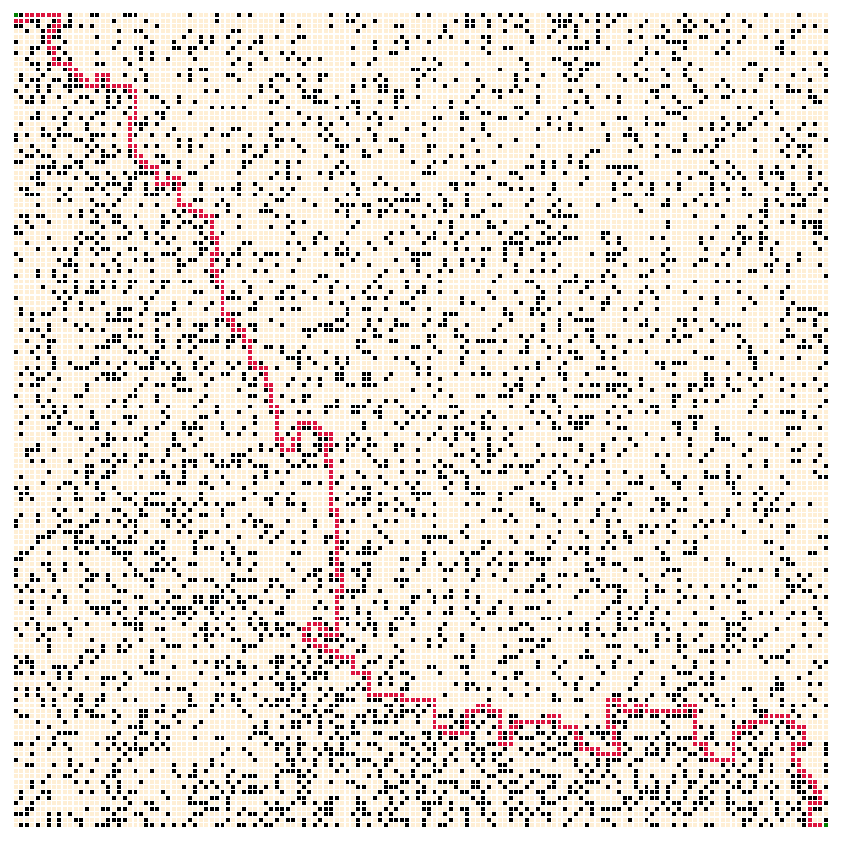

Cost of Hardest Maze: 5871
Difference between initial and hardest maze: 6.159756097560976
INITITAL MAZE


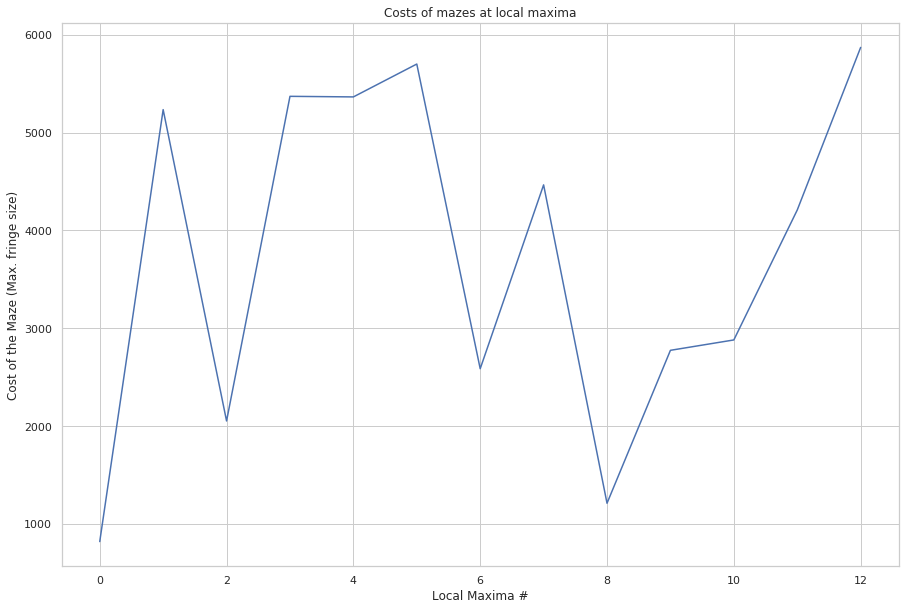

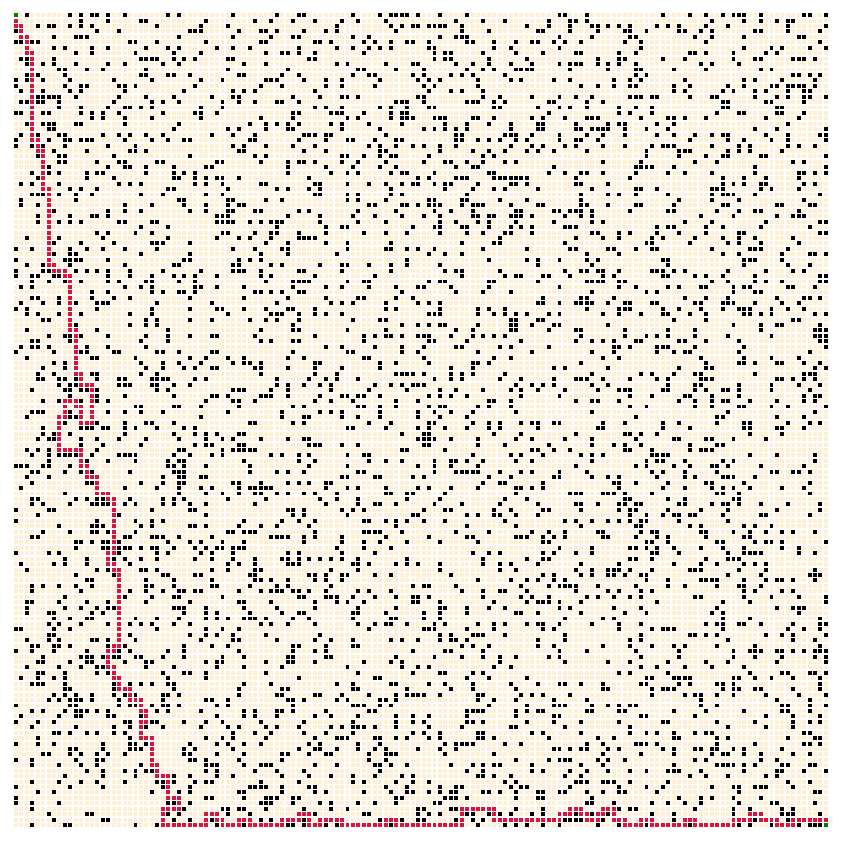

Cost of Initial Maze: 781
HARDEST MAZE


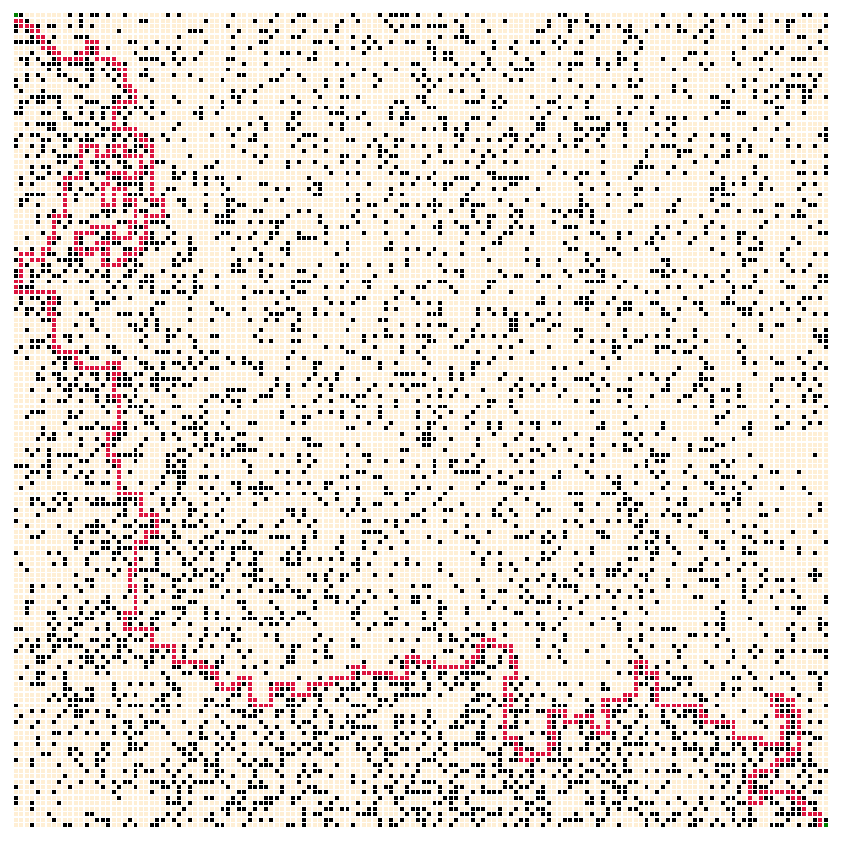

Cost of Hardest Maze: 16527
Difference between initial and hardest maze: 20.161331626120358
INITITAL MAZE


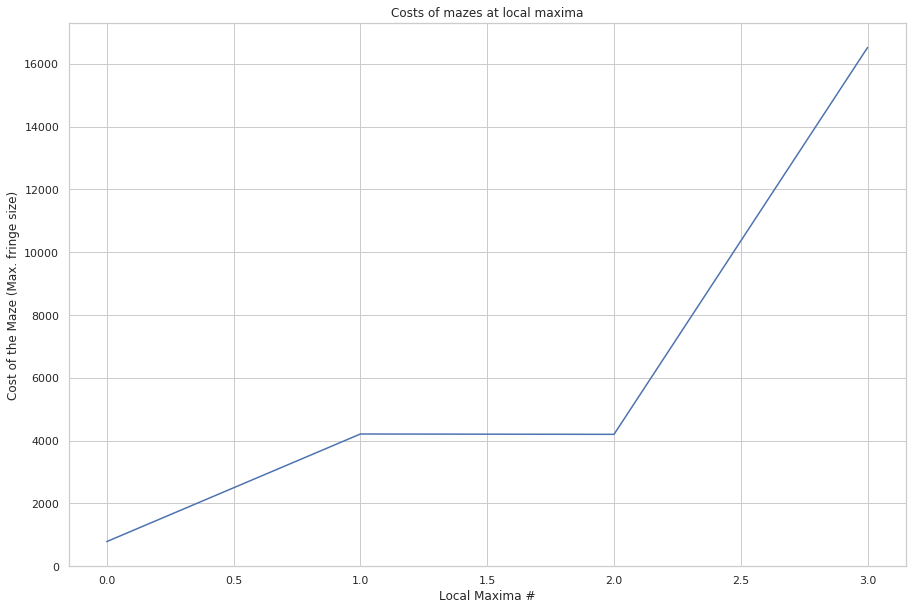

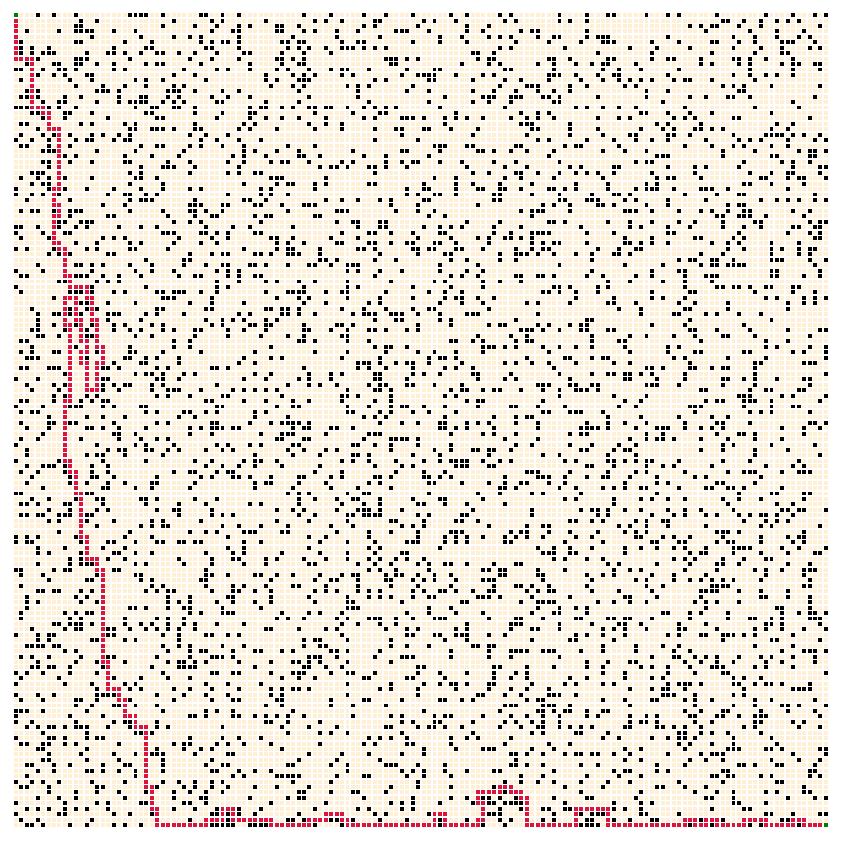

Cost of Initial Maze: 828
HARDEST MAZE


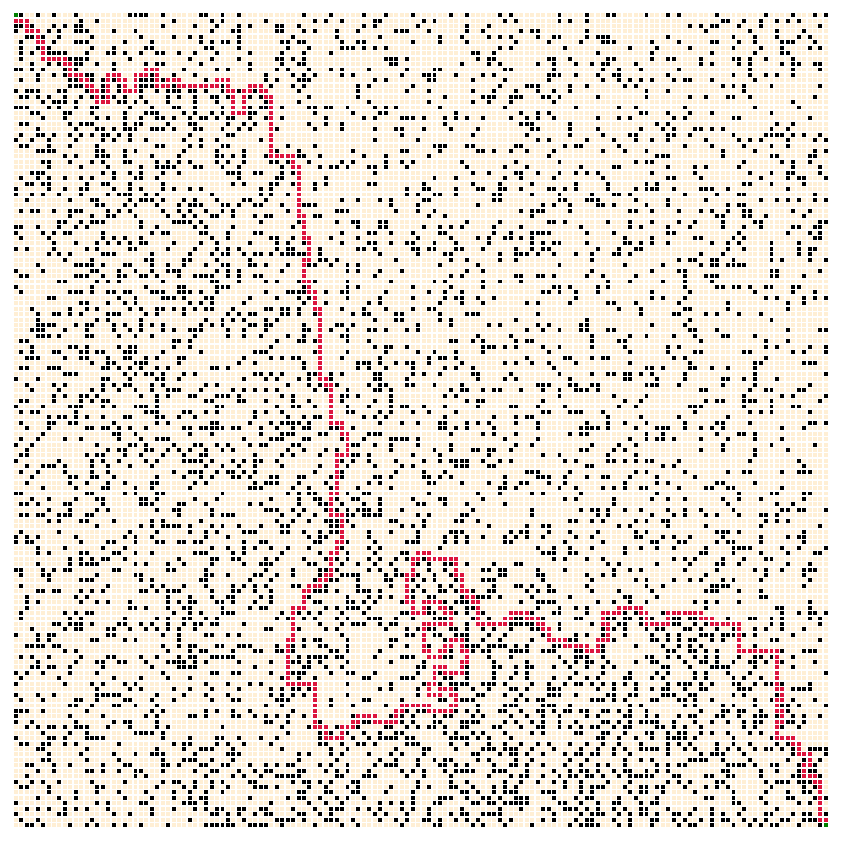

Cost of Hardest Maze: 7587
Difference between initial and hardest maze: 8.16304347826087
INITITAL MAZE


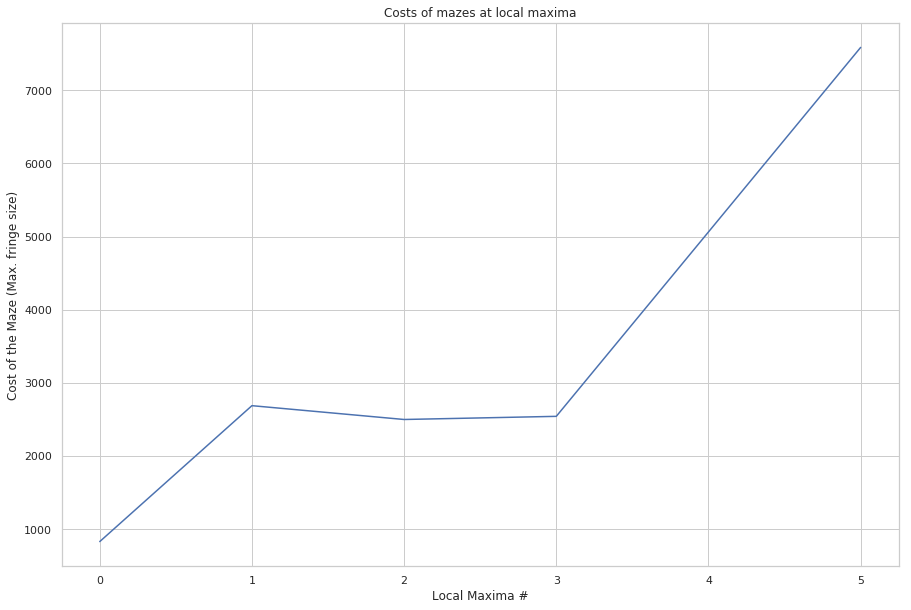

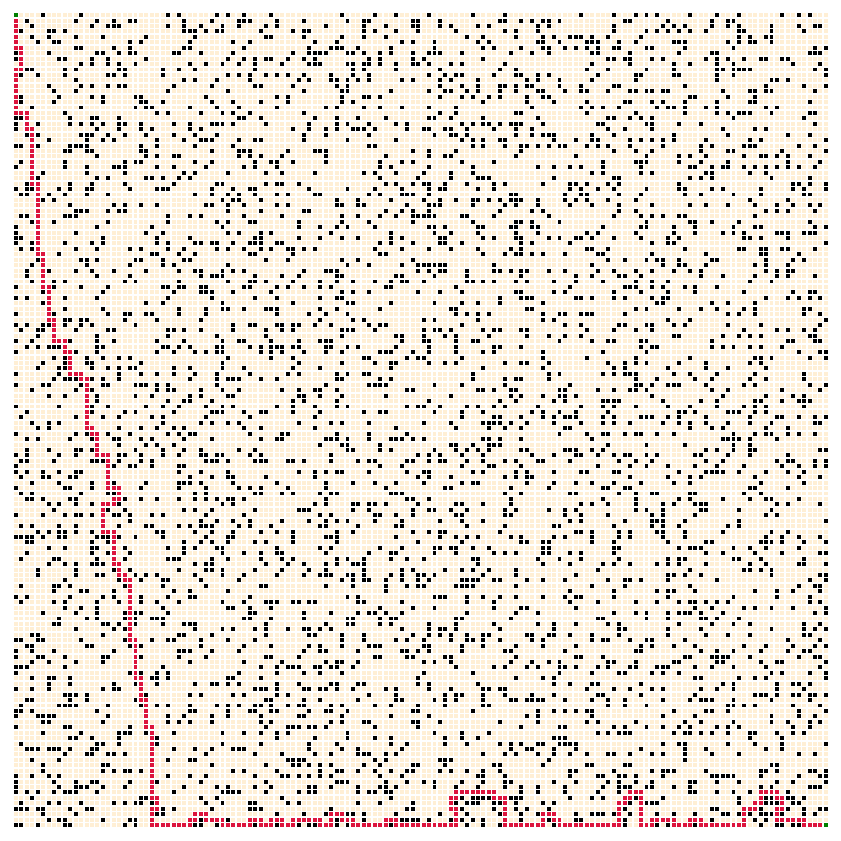

Cost of Initial Maze: 763
HARDEST MAZE


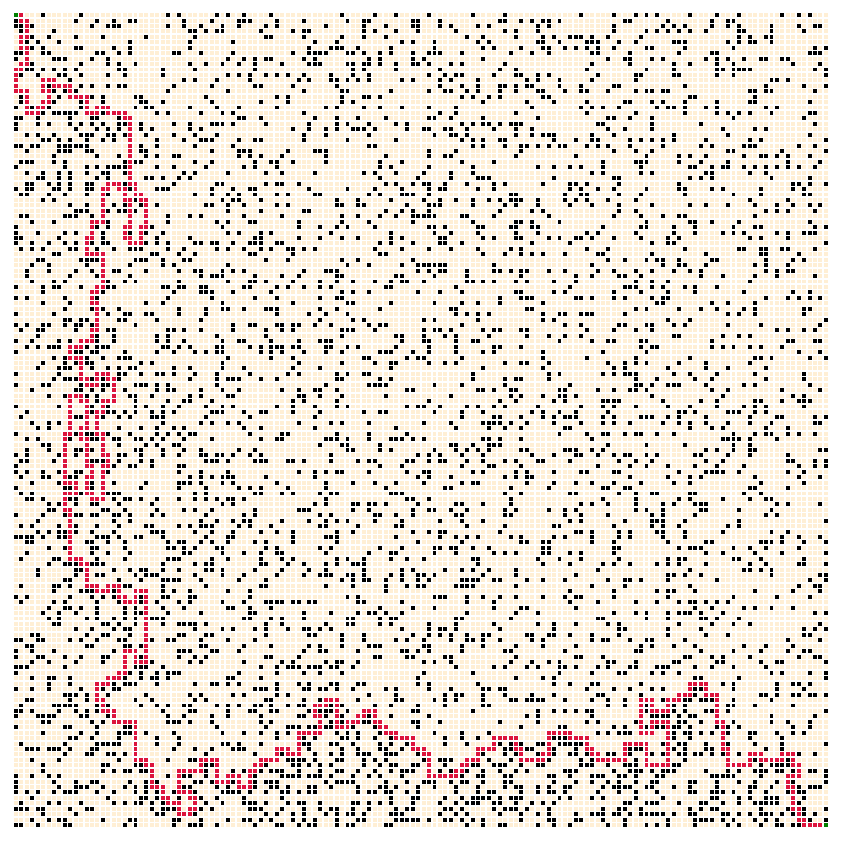

Cost of Hardest Maze: 15843
Difference between initial and hardest maze: 19.764089121887288


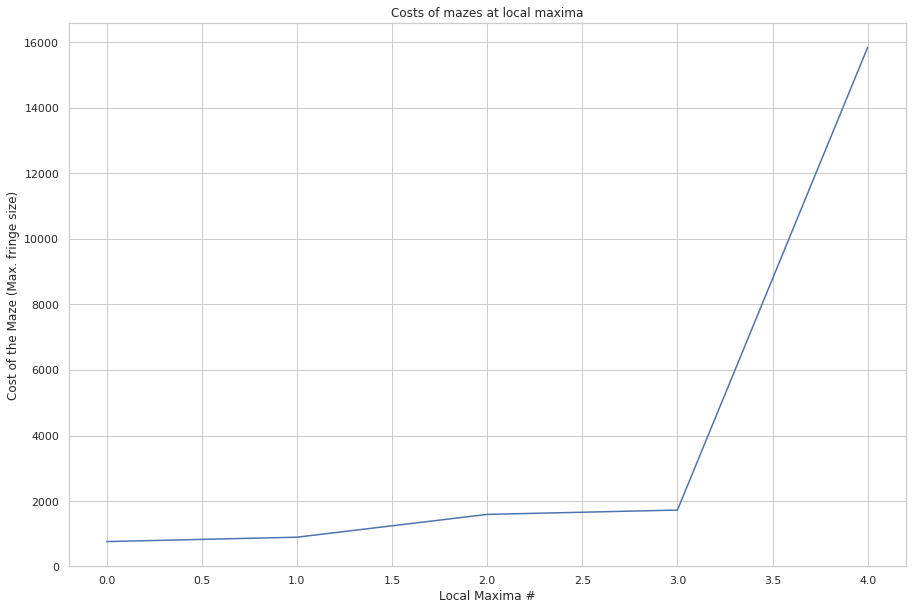

In [0]:
# Run multiple Hill climbing to find a hard maze:


num_restarts = 100
num_iterations = 5

final_maze, difference = multiple_hc(num_restarts, num_iterations)


FINAL HARDEST MAZE:


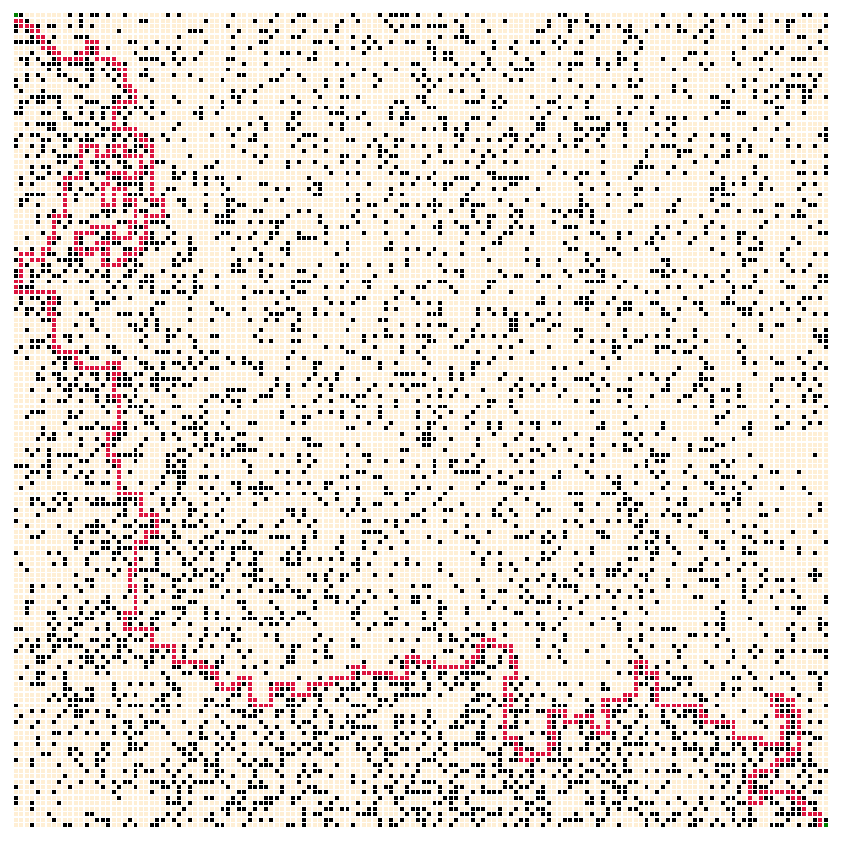

Cost of Final Maze: 16527


Text(0.5, 1.0, 'Cost difference at each iteration')

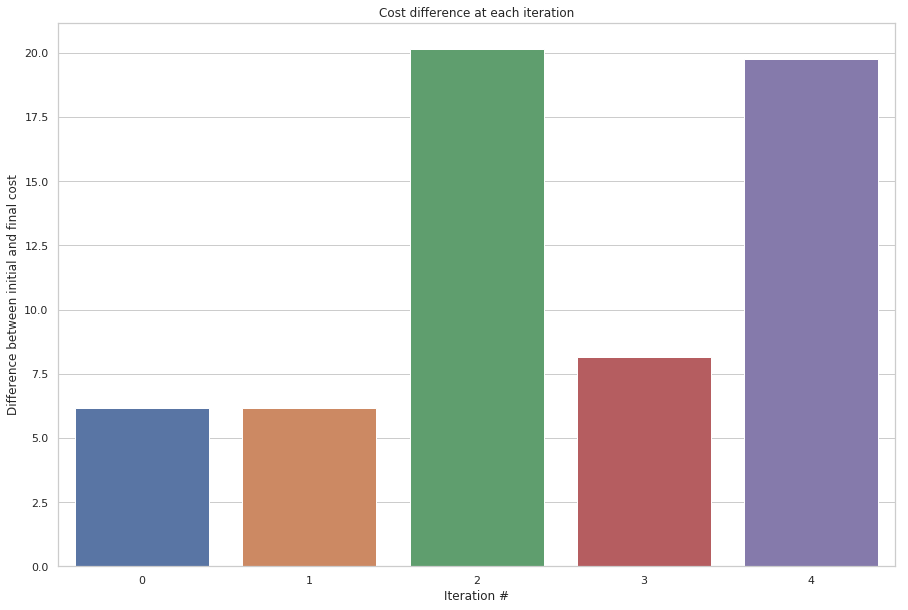

In [0]:
print("\nFINAL HARDEST MAZE:")
display_path(final_maze[0]*100, final_maze[2], start, goal)
print("Cost of Final Maze: " + str(final_maze[1]))

x = np.arange(len(difference))
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize = (15,10))
sns.barplot(x, difference)
plt.xlabel("Iteration #")
plt.ylabel("Difference between initial and final cost")
plt.title("Cost difference at each iteration")